# Ungraded Lab: U-Net for Image Segmentation

This notebook illustrates how to build a [UNet](https://arxiv.org/abs/1505.04597) for semantic image segmentation. This architecture is also a fully convolutional network and is similar to the model you just built in the previous lesson. A key difference is the use of skip connections from the encoder to the decoder. You will see how this is implemented later as you build each part of the network.

At the end of this lab, you will be able to use the UNet to output segmentation masks that shows which pixels of an input image are part of the background, foreground, and outline. 

<img src='https://drive.google.com/uc?export=view&id=1w8up90xVOYRT8vs5lNo2kEiVhm-7hWxZ' alt='sample_output'>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

I0107 14:46:07.679677 4330499584 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
oxford_iiit_pet:3.1.0
Traceback (most recent call last):
  File "/Users/shankar/dev/tools/anaconda3/envs/od/lib/python3.8/site-packages/tensorflow_datasets/core/utils/py_utils.py", line 399, in try_reraise
    yield
  File "/Users/shankar/dev/tools/anaconda3/envs/od/lib/python3.8/site-packages/tensorflow_datasets/core/registered.py", line 244, in builder
    return builder_cls(name)(**builder_kwargs)
  File "/Users/shankar/dev/tools/anaconda3/envs/od/lib/python3.8/site-packages/tensorflow_datasets/core/api_utils.py", line 69, in disallow_positional_args_dec
    return fn(*args, **kwargs)
  File "/Users/shankar/dev/tools/anaconda3/envs/od/lib/python3.8/site-packages/tensorflow_datasets/core/dataset_builder.py", line 200, in __init__
    self._version = self._pick_version(version)
  File "/Users/shankar/dev/tools/anaconda3/envs/od/lib/python3.8/site-packages/tensorflow_datasets/core

Shuffling and writing examples to /Users/shankar/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVZLHLF/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /Users/shankar/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVZLHLF/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /Users/shankar/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
# see the possible keys we can access in the dataset dict.
# this contains the test and train splits.
print(dataset.keys())

dict_keys(['test', 'train'])


In [5]:
# see information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

## Prepare the Dataset
You will now prepare the train and test sets. The following utility functions preprocess the data. These include:

* simple augmentation by flipping the image
* normalizing the pixel values  
* resizing the images

Another preprocessing step is to adjust the segmentation mask's pixel values. The `README` in the [annotations](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz) folder of the dataset mentions that the pixels in the segmentation mask are labeled as such:

| Label            | Class Name     |
| -------------    | -------------  |
| 1                | foreground     |
| 2                | background     |
| 3                | Not Classified |

<br>
<br>

For convenience, let's subtract `1` from these values and we will interpret these as `{'pet', 'background', 'outline'}`:

| Label            | Class Name     |
| -------------    | -------------  |
| 0                | pet            |
| 1                | background     |
| 2                | outline        |

In [7]:
# Preprocessing Utilities

def random_flip(input_image, input_mask):
    '''does a random flip of the image and mask'''
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image, input_mask):
    '''
    normalizes the input image pixel values to be from [0,1].
    subtracts 1 from the mask labels to have a range from [0,2]
    '''
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


@tf.function
def load_image_train(datapoint):
    '''resizes, normalizes, and flips the training data'''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    '''resizes and normalizes the test data'''
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

In [10]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
    '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''

    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)

    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
    '''displays a list of images/masks'''

    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
          plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)

    plt.show()


def show_image_from_dataset(dataset):
    '''displays the first image and its mask from a dataset'''

    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
    '''plots a given metric from the model history'''
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
    plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

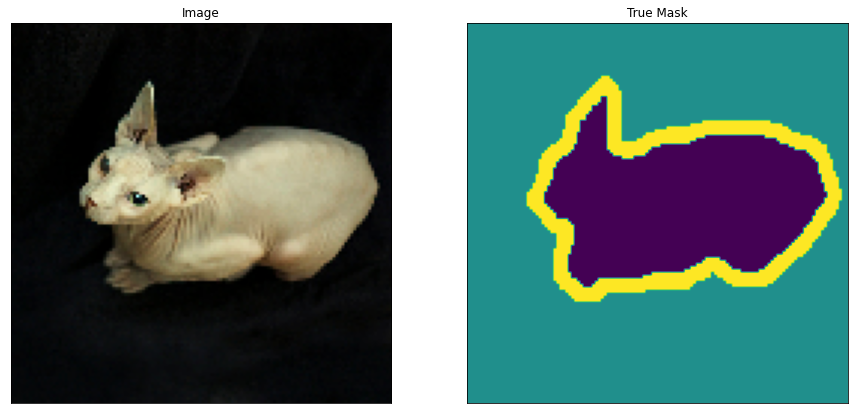

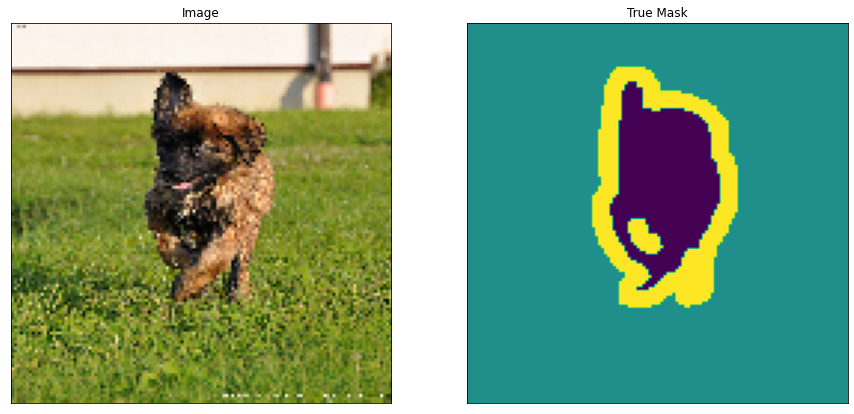

In [11]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

## Define the model

With the dataset prepared, you can now build the UNet. Here is the overall architecture as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

### Encoder

Like the FCN model you built in the previous lesson, the encoder here will have repeating blocks (red boxes in the figure below) so it's best to create functions for it to make the code modular. These encoder blocks will contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. As discussed in class, each stage will have increasing number of filters and the dimensionality of the features will reduce because of the pooling layer.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(
            filters=n_filters,
            kernel_size=(kernel_size, kernel_size),
            kernel_initializer = 'he_normal', 
            padding = 'same'
        )(x)
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

In [14]:
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    
    return f, p

In [15]:
def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=64, pool_size=(2, 2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=64, pool_size=(2, 2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=64, pool_size=(2, 2), dropout=0.3)
    
    return p4, (f1, f2, f3, f4)

### Bottleneck


A bottleneck follows the encoder block and is used to extract more features. This does not have a pooling layer so the dimensionality remains the same. You can use the `conv2d_block()` function defined earlier to implement this.

In [16]:
def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more 
    features before the upsampling layers.
    '''

    bottle_neck = conv2d_block(inputs, n_filters=1024)

    return bottle_neck

### Decoder

Finally, we have the decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block. This is summarized in the figure below.

<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [18]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    
    u = tf.keras.layers.Conv2DTranspose(
        n_filters, kernel_size, strides=strides,
        padding='same'
    )(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)
    
    return c

In [19]:
def decoder(inputs, convs, output_channels):
    f1, f2, f3, f4 = convs
    c6 = decoder_block(
        inputs, f4, n_filters=512,
        kernel_size=(3, 3), strides=(2, 2),
        dropout=0.3
    )
    c7 = decoder_block(
        c6, f3, n_filters=256,
        kernel_size=(3, 3), strides=(2, 2),
        dropout=0.3
    )
    c8 = decoder_block(
        c7, f2, n_filters=128,
        kernel_size=(3, 3), strides=(2, 2),
        dropout=0.3
    )
    c9 = decoder_block(
        c8, f1, n_filters=64,
        kernel_size=(3, 3), strides=(2, 2),
        dropout=0.3
    )
    
    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)
    
    return outputs

In [24]:
OUTPUT_CHANNELS = 3

def unet():
    # Specify the input shape
    inputs = tf.keras.layers.Input(shape=(128, 128, 3,))
    
    # feed the inputs to the encoder
    encoder_output, convs = encoder(inputs)
    
    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output)
    
    # Feed the bottleneck and encoder block output to the decoder
    # specify the number of classes via the output channels argument
    outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
    
    # Creart the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model



In [25]:
# Instantiate the model
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 128, 128, 64) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 64) 36928       activation_20[0][0]              
______________________________________________________________________________________________

In [26]:
# configure the optimizer, loss and metrics for training
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset
)

In [ ]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

In [29]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
    '''
    Unpacks the test dataset and returns the input images and segmentation masks
    '''

    ds = test_dataset.unbatch()
    ds = ds.batch(info.splits['test'].num_examples)

    images = []
    y_true_segments = []

    for image, annotation in ds.take(1):
        y_true_segments = annotation.numpy()
        images = image.numpy()

    y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

    return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
    '''
    Creates the segmentation mask by getting the channel with the highest probability. Remember that we
    have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
    highest probability.
    '''
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
    '''
    Feeds an image to a model and returns the predicted mask.
    '''

    image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)

    return pred_mask 

### Compute class wise metrics

Like the previous lab, you will also want to compute the IOU and Dice Score. This is the same function you used previously.

In [30]:
def class_wise_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001
    for i in range(3):

        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [ ]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

In [ ]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 


In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)